# Análise Comparativa de Modelos

Nesse notebook iremos olhar para os textos obtidos na primeira unidade para construir modelos de aprendizado de máquina. Para isso, precisaremos de algumas bibliotecas já conhecidas (*pandas, nltk, numpy*) e de outras novas, relacionadas à:
- preparação dos dados: 
    - *CountVectorizer*, 
    - *TfidfVectorizer*,
    - *TruncatedSVD*
    - *StandardScaler*
- aprendizagem em si: 
    - *LogisticRegression*, 
    - *KNeighborsClassifier*, 
    - *SVC*, 
    - *RandomForestClassifier*
    - *GradientBoostingClassifier*
- construção da sequência de passos a realizar:
    - *Pipeline*
- avaliação e seleção dos modelos obtidos:
    - *ShuffleSplit*,
    - *cross_validate*
    
Algumas dessas funções serão explicadas adiante. Sigamos.

## Importando bibliotecas

In [1]:
%reload_ext autoreload
%autoreload 2

import pickle # salva e carrega objetos python
from functools import partial
from itertools import \
    product  # produto cartesiano de duas listas sem precisar de for aninhados

import joblib # salva e carrega objetos python
import nltk  # ferramentas p/ processamento de linguagem natural
import numpy as np  # manipulação de matrizes, funções matemáticas
import pandas as pd  # manipulação de dataframes
import seaborn as sns # visualização de dados
from matplotlib import pyplot as plt # visualização de dados
from sklearn.decomposition import TruncatedSVD 
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (KFold, RandomizedSearchCV, ShuffleSplit,
                                     cross_validate)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC

from src.data import \
    organize  # pacote interno para gerenciamento e exibição dos resultados


## Carregando Dados

Aqui temos o conjunto de dados que será utilizado na análise comparativa. Ele contém 6 colunas, todas de texto, sendo elas duas originais:

- `text`: contendo o texto original obtido na primeira etapa
- `label`: com o rótulo da respectiva notícia (`fake` para notícias falsas ou `true` para verdadeiras)

E quatro geradas por processamento com remoção de datas, caracteres especiais, nomes de dia da semana, letras maiúsculas e ainda:

- `lemmatization_plus_stop_words`: string versões deflexionadas das palavras da coluna `text`. Exemplos: *doa* $\rightarrow$ *doar*; *eventos* $\rightarrow$ *evento*.
- `stemming_plus_stop_words`: string com versões de palavras da coluna `text` sem seus respectivos sufixos, desinências e outros. Exemplos: *herdeira* $\rightarrow$ *herd*; *incinerada* $\rightarrow$ *inciner*.
- `lemmatization_wo_stop_words`: palavras da coluna `lemmatization_plus_stop_words` com exceção de termos comuns e de baixo valor semântico, conhecidos como *stopwords*. 
- `stemming_wo_stop_words`: palavras da coluna `stemming_plus_stop_words` com exceção de termos comuns e de baixo valor semântico, conhecidos como *stopwords*. 

Todos esses conjuntos serão avaliados junto aos modelos para identificação da melhor combinação processamento de texto + modelo dentre os disponíveis.

In [2]:
# Adquire dados do arquivo produzido na etapa anterior
df = pd.read_csv('../data/processed/textos_pre-processados.csv')
df.sample(5)

# Atribui codificação dos rótulos das notícias
labels = df.label.replace({"true": 1, "fake": 0})

## Conversão dos textos (Vetorizadores)

Para um emprego bem-sucedido dos modelos de aprendizado frente a dados de texto é necessária a conversão desses dados em forma de string longa em outra estrutura; isto pode ser feito por vetorizadores.

### CountVectorizer

Esse método de conversão cria uma matriz com a contagem de todas as palavras presentes em todos os textos considerados. Esse método também é chamado de Bag of Words, ou Saco de Palavras.

![CountVectorizer](images/count-vectorizer.png)

### TfidfVectorizer

Esse método de conversão cria uma matriz que considera dois valores: TF e DF. TF ($tf_{i,j}$) é a contagem de uma palavra ($i$) no texto ($j$), tal como é calculada pelo CountVectorizer. Já DF ($df_{i}$) diz respeito à quantidade de textos em que aquela palavra aparece. No cálculo, o valor para uma dada palavra ($w_{i,j}$) é dado por:

$ w_{i,j} = tf_{i,j} \times log(\frac{N}{df_{i}}) $

Em que $N$ é o número total de documentos. Como $df_{i}$ está no denominador do logarítmo, trata-se de uma conversão que considera TF e o inverso de DF, iDF.

![CountVectorizer](images/tfidf-vectorizer.png)

Em ambos os casos, palavras comuns e sem importância semântica no idioma trabalhado devem ser removidas. Afinal, caso fossem consideradas na conversão TFiDF, as palavras "de" e "desse" no primeiro texto teriam o mesmo peso da palavra "corrupção" e "suspeito", com importância semântica superior.


O número ideal de palavras mais frequentes a serem utilizadas nas conversões também serão avaliados no processo de comparação dos modelos obtidos.

In [3]:
vectorizer = Pipeline([
    ('count', CountVectorizer()),
    ('tfidf', TfidfTransformer())
])

## Modelos de Aprendizagem de Máquina

### Regressão Logística

A regressão logística, que é um modelo classificador, utiliza uma função logística para calcular as probabilidades de uma notícia ser falsa ou verdadeira. A função logística por trás deste modelo é uma curva sigmoide contendo as probabilidades de classificação em uma determinada categoria (notícia falsa ou verdadeira). A partir disso se encontra um valor limite dentro da curva para que então se obtenham as predições.

### KNN

Aqui a classificação das notícias em falsas ou verdadeira é feita com base nos K-vizinhos mais próximos (*K-Nearest Neighbors*) a ela. Se utilizamos $K = 10$ e dentre as 10 notícias mais próximas de uma notícia $i$ no nosso espaço dimensional, 6 são falsas e 4 são verdadeiras, esta notícia $i$ será classificada como falsa.

### SVC

O SVC é um *Support Vector Classifier*, isso é, um algoritmo de classificação que utiliza vetores (dados) como suporte para definir um hiperplano que separe dados de um grupo dos dados de outro grupo. No nosso caso, o SVC busca um hiperplano que separe as matrizes produzidas a partir de notícias falsas daquelas de notícias verdadeiras.

<details>
    <summary>Ler Mais</summary>
    O hiperplano pode ser obtido após uma transformação dos dados, na qual eles saem de seu espaço dimensional original, intrínseco, e são levados a um espaço dimensional superior. Essa transformação é feita através através de diversas fórmulas matemáticas para que então o hiperplano ideal - aquele que separa os dados com melhor margem - seja identificado; este é o chamado *kernel trick*.
    </details>

### Random Forest

A *Random Forest*, uma floresta aleatória, é um método que faz uso de diversas Árvores de Decisão, *Decision Trees*. As árvores de decisão são aquelas que fazem sucessivas divisões nos dados utilizando as características disponíveis de modo a obter grupos que sejam o mais diferentes entre si e o mais coesos internamente. Exemplo de divisão para separação de grupos: textos que têm a palavra ministro e textos que não têm, textos contendo a palavra corrupção e textos que não tem.

<details>
    <summary>Ler Mais</summary>
    Contando então com várias árvores de decisão, a *Floresta*, é um classificador do tipo *ensemble*, pois considera diferentes predições finais para cada texto pelas diferentes árvores. A predição prevalente para um dado texto é então incorporada à saída da *Random Forest*. Como as árvores de decisão não são dependentes entre si, possuindo critérios próprios e não relacionados, a Random Forest minimiza o viés que viria do uso de uma única árvore, se tornando um modelo poderoso.</details>

### Gradient Boosting Classifier

O método de classificação por *Gradient Boosting* também se utiliza de outros preditores. Nesse caso específico, os preditores agregados são fracos - tem baixa acurácia - e cada preditor avalia e foca em fazer uma boa predição dos erros do modelo anterior a ele. Ou seja, a cada novo preditor utilizado, os dados para predição são apenas os erros deixados pelo modelo anterior.

## Busca em Grade

Para comparar os diversos modelos foi realizada uma busca em grade pelos melhores hiperparâmetros de cada modelo de acordo com o F1-Score. Para cada modelo foram identificados alguns hiperparâmetros e valores de referência com impacto no desempenho final, dentre os atribuídos a seguir:

In [4]:
models = [{
    'name': 'LR',
    'model': LogisticRegression(solver='liblinear'),
    'parameters':{
        'penalty': ['l1', 'l2'],
        'C' : np.logspace(-4, 4, 10),
    }
},{
    'name': 'KNN',
    'model': KNeighborsClassifier(algorithm='kd_tree'),
    'parameters': {
        'n_neighbors': np.arange(3, 21, 2),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan'],
        # 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
    }
},{
    'name': 'RF',
    'model': RandomForestClassifier(),
    'parameters':{
        'n_estimators': [200, 500],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [4,5,6,7,8],
        'criterion' :['gini', 'entropy'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'bootstrap': [True, False]
    },
},{
    'name': 'SVC',
    'model': SVC(max_iter=10000, gamma='auto', probability=True),
    'parameters':{
        "C": [1e-5, 1e-4, 1e-3, 1, 10, 100, 1000, 1e5]
    }
},{
        'name': 'GB',
        'model': GradientBoostingClassifier(),
        'parameters':{
            'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
            'min_samples_split': np.linspace(0.1, 0.5, 12),
            'min_samples_leaf': np.linspace(0.1, 0.5, 12),
            'max_depth':[3,5,8],
            'max_features':['log2','sqrt'],
            'criterion': ['friedman_mse',  'squared_error'],
            'subsample':[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
            'n_estimators':[10]
    }
}]

## Redução de Dimensionalidade

Quando trabalhamos com texto é natural que o resultado das transformações dos textos em vetores (CountVectorizer, TFiDFVectorizer, etc) seja uma matriz esparsa, pois grande parte das palavras NÃO estará presente em diversos textos. Desse modo, pode ser vantajoso aplicar uma redução de dimensionalidade. Na etapa de transformação, ficamos com mil *features*, referentes às ocorrências das palavras mais frequentes. 

A função TruncatedSVD é usada para reduzir a matriz esparsa, ficando apenas com as ocorrências das A palavras menos esparsas dentre as B mais frequentes. A decomposição em valores singulares (*singular value decomposition*, SVD) transforma a matriz recebida e a leva para um espaço dimensional menor, reduzindo o efeito de sinônimos e palavras similares, as quais são usadas de maneira alternada pelos textos.

## Normalização

Na normalização os valores são transformados de forma a escala das diferentes características, isso reduz as chances de superestimação ou subestimação de determinadas *features* em função de seus valores padrão. Aqui, foi empregada uma normalização do tipo Z ou padronização, que subtrai a média da distribuição do para cada valor e divide o resultado pelo desvio padrão para aquela característica. Essa é uma maneira de normalizar sem alterar a distribuição das features, seja qual for.

In [5]:
pca = TruncatedSVD()
scaler = StandardScaler()

## Validação Cruzada

Para testar a robustez dos modelos indicados pela busca em grade e compará-los, a validação cruzada foi feita sobre N divisões aleatórias dos dados, conservando 80% deles para o conjunto de treinamento e 20% para teste. Ao final, os escores de avaliação (acurácia, F1-score) obtidos foram armazenados.

### Acurácia

Esta medida de avaliação considera os acertos que o modelo realizou, sejam eles ao classificar notícias falsas como falsas ou notícias verdadeiras como verdadeiras. Todos os acertos são computados e calculados em forma de porcentagem em relação ao número total de dados. Esta é uma métrica interessante quando ambas as categorias são igualmente importantes. No código:`accuracy`

### F1

No nosso caso, como detector de notícias falsas, pode ser mais interessante, caso seja necessário, priorizar modelos que tenham melhor desempenho em corretamente rotular notícias falsas. Nesse caso, o *F1-score* (`f1`) é uma boa medida para a avaliação dos erros (falsos positivos e falsos negativos) e será dado pela média harmônica entre precisão e sensibilidade. No nosso caso:

- Precisão (`precision`)
> Proporção dada pelo # de notícias falsas corretamente classificadas como falsas e o # total de notícias classificadas como falsas . 
- Sensibilidade (`recall`)
> Proporção dada pelo # de notícias corretamente classificadas como falsas dividido pelo # notícias realmente falsas. 
- Área sob a Curva ROC (`roc_auc`)
> A curva ROC representa o desempenho do classificador conforme mudam seus limites de classificação. A curva é desenhada pela relação entre sensibilidade (casos positivos classificados corretamentes divididos por todos os casos positivos) e RPF (casos negativos classificados corretamentes divididos por todos os casos negativos).

Quão mais próximos de 1 chegam os valores dessas métricas, quão melhores são os modelos de onde foram extraídos.

In [6]:
n_splits_cv = 10
n_splits_cv_grid_search = 5
model_scores = []

dataset_names = ['text', 'lemmatization_plus_stop_words', 'stemming_plus_stopwords', 'lemmatization_wo_stopwords', 'stemming_wo_stopwords']
for dataset_name in dataset_names:
    corpus = df[dataset_name].to_list()
    #label_encoder = LabelEncoder()
    #labels = label_encoder.fit_transform(df.label)
    labels = df.label.replace({"true": 1, "fake": 0})
    for model in models:
        approach_name = f"{dataset_name}-{model['name']}"
        print(f"running {approach_name}")
        param_grid = {
            'vectorizer__tfidf__use_idf': [False, True],
            'vectorizer__count__max_features': [1000, 2000],
            'pca__n_components': [100, 200, 500],
            **{f"model__{key}": value for key, value in model['parameters'].items()}
        }
        approach = Pipeline([
            ("vectorizer", vectorizer),
            ("pca", pca),
            ("normalize", scaler),
            ('model', model['model'])
        ])

        gs = RandomizedSearchCV(
            estimator=approach,
            param_distributions=param_grid,
            scoring='f1',
            cv=n_splits_cv_grid_search,
            random_state=24
        )

        scores = cross_validate(
            estimator=gs,
            X=corpus,
            y=labels,
            cv=ShuffleSplit(n_splits=n_splits_cv, test_size=.2),
            n_jobs=35,
            scoring=['accuracy', 'precision', 'recall','f1', 'roc_auc'],
        )
        scores['model'] = [approach_name] * n_splits_cv
        model_scores.append(scores)

running text-LR


running text-KNN


running text-RF


running text-SVC


running text-GB


running lemmatization_plus_stop_words-LR


running lemmatization_plus_stop_words-KNN


running lemmatization_plus_stop_words-RF


running lemmatization_plus_stop_words-SVC


running lemmatization_plus_stop_words-GB


running stemming_plus_stopwords-LR


/storages/caico/home/taynafiuza/.cache/pypoetry/virtualenvs/src-ahMoboP9-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/storages/caico/home/taynafiuza/.cache/pypoetry/virtualenvs/src-ahMoboP9-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/storages/caico/home/taynafiuza/.cache/pypoetry/virtualenvs/src-ahMoboP9-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/storages/caico/home/taynafiuza/.cache/pypoetry/virtualenvs/src-ahMoboP9-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


/storages/caico/home/taynafiuza/.cache/pypoetry/virtualenvs/src-ahMoboP9-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/storages/caico/home/taynafiuza/.cache/pypoetry/virtualenvs/src-ahMoboP9-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


running stemming_plus_stopwords-KNN


running stemming_plus_stopwords-RF


running stemming_plus_stopwords-SVC


running stemming_plus_stopwords-GB


running lemmatization_wo_stopwords-LR


/storages/caico/home/taynafiuza/.cache/pypoetry/virtualenvs/src-ahMoboP9-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/storages/caico/home/taynafiuza/.cache/pypoetry/virtualenvs/src-ahMoboP9-py3.8/lib/python3.8/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


running lemmatization_wo_stopwords-KNN


running lemmatization_wo_stopwords-RF


running lemmatization_wo_stopwords-SVC


running lemmatization_wo_stopwords-GB


running stemming_wo_stopwords-LR


running stemming_wo_stopwords-KNN


running stemming_wo_stopwords-RF


running stemming_wo_stopwords-SVC


running stemming_wo_stopwords-GB


In [7]:
organize.save_object(model_scores, '../models/model_scores.pkl')

## Comparação dos modelos
### Tabela

Em que os resultados são agrupados de acordo com os modelos e são calculadas média e desvio padrão dos M modelos gerados para cada combinação de conjunto de dados e método de aprendizagem de máquina.

In [8]:
scores = organize.concatenate(*model_scores)

In [9]:
results = (
    pd
    .DataFrame(scores)
    .groupby(['model'])
    .agg([lambda x: f"{np.mean(x):.3f} ± {np.std(x):.3f}"])#
    .transpose()
    .reset_index()
    .rename(columns={"level_0": "score"})
    .drop(columns="level_1")    
)

Nesta tabela temos informações relacionadas às metricas citadas acima, conforme computadas para o conjunto teste. As células que computam estas métricas em seu máximo valor estão coloridas.

### Figura

Para produzir a figura os dados provenientes dos resultados passaram por uma pequena modificação para que cada método de aprendizado e cada vetorizador ficasse em uma coluna específica.

In [10]:
results_df = (
    pd
    .DataFrame(scores)
)

results_df[['dataset','model_type']] = results_df.model.str.split('-', expand=True)

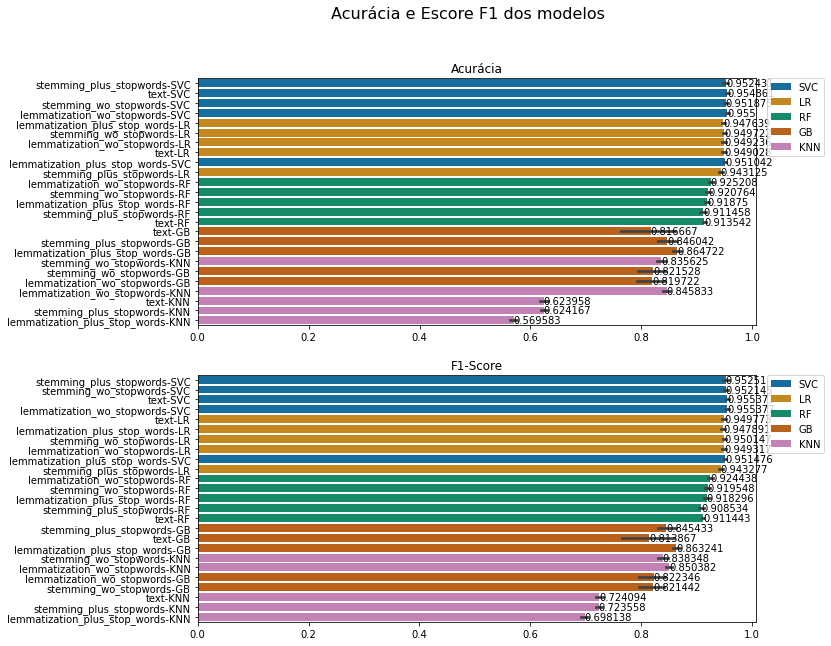

In [11]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,10))
fig.suptitle('Acurácia e Escore F1 dos modelos', fontsize=16)

results_df = results_df.sort_values(['test_accuracy'], ascending=False)
sns.barplot(x="test_accuracy", y="model", 
            data=results_df, ax=ax1, 
            palette="colorblind", hue="model_type", dodge=False)
ax1.set_title("Acurácia")
ax1.set(xlabel=None, ylabel=None)
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0) 
for container in ax1.containers:
    ax1.bar_label(container)

results_df = results_df.sort_values(['test_f1'], ascending=False)
sns.barplot(x="test_f1", y="model", 
            data=results_df, ax=ax2, 
            palette="colorblind", hue="model_type", dodge=False)
ax2.set_title("F1-Score")
ax2.set(xlabel=None, ylabel=None)
ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0) 
for container in ax2.containers:
    ax2.bar_label(container)

plt.show()

In [12]:
results_df.drop(columns=['dataset', 'model_type'], inplace=True)
res_df = results_df.groupby("model").agg([np.mean, np.std]).reset_index()
res_df.columns = ['_'.join(col).strip() for col in res_df.columns.values]

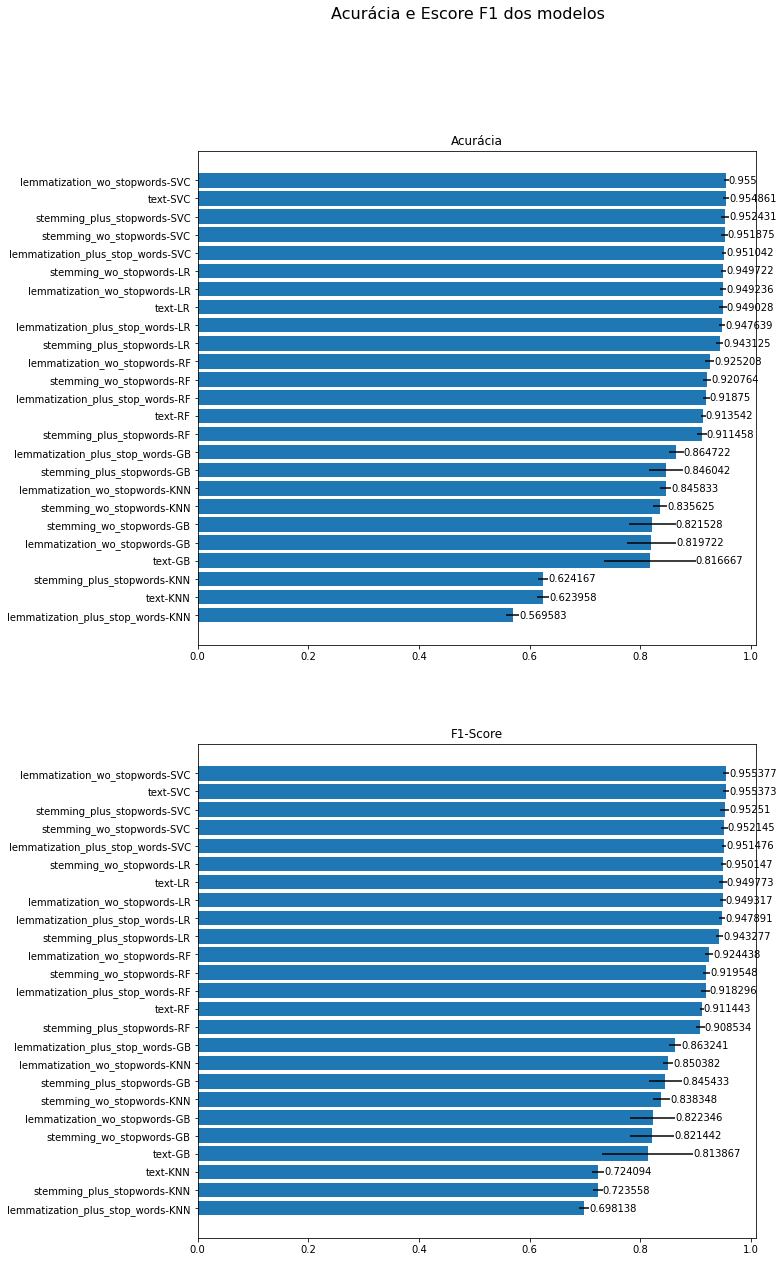

In [13]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,20))
fig.suptitle('Acurácia e Escore F1 dos modelos', fontsize=16)

res_df = res_df.sort_values(['test_accuracy_mean'], ascending=True)
bars = ax1.barh(y=res_df.model_,
         width=res_df.test_accuracy_mean,
         xerr=res_df.test_accuracy_std)
ax1.set_title("Acurácia")
ax1.set(xlabel=None, ylabel=None)
ax1.bar_label(bars)

res_df = res_df.sort_values(['test_f1_mean'], ascending=True)
bars = ax2.barh(y=res_df.model_,
         width=res_df.test_f1_mean,
         xerr=res_df.test_f1_std)
ax2.set_title("F1-Score")
ax2.set(xlabel=None, ylabel=None)
ax2.bar_label(bars)

plt.show()

## Seleção do melhor modelo

Baseia-se na escolha do modelo com melhores escores para a maior parte das métricas avaliadas.

In [14]:
time_scores = ['fit_time', 'score_time']
get_winner = partial(organize.get_winner, models=results.columns[1:])
winner = (
    results
    .query('score not in @time_scores')
    .apply(get_winner, axis=1)
    .value_counts()
    .index[0]
)
results.columns.name = ''
results = (
    results
    .style
    .hide(axis='index')
    .apply(organize.highlight_max, props='color:white;background-color:blue', axis=1)
)
display(results)
print(f'O melhor modelo é o {winner}')

score,lemmatization_plus_stop_words-GB,lemmatization_plus_stop_words-KNN,lemmatization_plus_stop_words-LR,lemmatization_plus_stop_words-RF,lemmatization_plus_stop_words-SVC,lemmatization_wo_stopwords-GB,lemmatization_wo_stopwords-KNN,lemmatization_wo_stopwords-LR,lemmatization_wo_stopwords-RF,lemmatization_wo_stopwords-SVC,stemming_plus_stopwords-GB,stemming_plus_stopwords-KNN,stemming_plus_stopwords-LR,stemming_plus_stopwords-RF,stemming_plus_stopwords-SVC,stemming_wo_stopwords-GB,stemming_wo_stopwords-KNN,stemming_wo_stopwords-LR,stemming_wo_stopwords-RF,stemming_wo_stopwords-SVC,text-GB,text-KNN,text-LR,text-RF,text-SVC
fit_time,284.069 ± 2.360,505.637 ± 2.297,663.519 ± 132.157,1566.611 ± 2.501,803.516 ± 13.943,233.454 ± 1.822,451.949 ± 3.785,367.308 ± 17.945,1516.177 ± 3.838,1234.040 ± 75.312,283.215 ± 1.810,502.821 ± 4.831,495.331 ± 163.660,1569.742 ± 5.805,853.348 ± 24.241,225.639 ± 2.417,445.130 ± 4.019,349.427 ± 14.285,1512.180 ± 3.515,1186.845 ± 45.966,293.230 ± 2.397,516.479 ± 3.081,414.866 ± 14.498,1583.488 ± 4.702,872.442 ± 27.555
score_time,1.452 ± 0.110,4.587 ± 0.077,1.443 ± 0.140,1.577 ± 0.105,3.146 ± 0.801,1.003 ± 0.062,4.026 ± 0.236,1.018 ± 0.088,1.105 ± 0.075,5.071 ± 1.404,1.406 ± 0.075,4.396 ± 0.195,1.382 ± 0.101,1.484 ± 0.078,3.048 ± 0.886,0.931 ± 0.066,3.991 ± 0.245,0.972 ± 0.074,1.037 ± 0.057,3.345 ± 1.045,1.476 ± 0.120,4.525 ± 0.210,1.481 ± 0.125,1.534 ± 0.089,2.813 ± 0.685
test_accuracy,0.865 ± 0.013,0.570 ± 0.011,0.948 ± 0.005,0.919 ± 0.006,0.951 ± 0.004,0.820 ± 0.042,0.846 ± 0.009,0.949 ± 0.005,0.925 ± 0.008,0.955 ± 0.004,0.846 ± 0.029,0.624 ± 0.009,0.943 ± 0.006,0.911 ± 0.008,0.952 ± 0.007,0.822 ± 0.040,0.836 ± 0.012,0.950 ± 0.005,0.921 ± 0.007,0.952 ± 0.005,0.817 ± 0.079,0.624 ± 0.010,0.949 ± 0.006,0.914 ± 0.004,0.955 ± 0.005
test_precision,0.871 ± 0.022,0.538 ± 0.011,0.946 ± 0.007,0.928 ± 0.008,0.950 ± 0.008,0.813 ± 0.047,0.830 ± 0.018,0.951 ± 0.006,0.942 ± 0.008,0.954 ± 0.009,0.856 ± 0.048,0.572 ± 0.011,0.940 ± 0.009,0.927 ± 0.008,0.951 ± 0.013,0.828 ± 0.053,0.832 ± 0.014,0.950 ± 0.009,0.932 ± 0.008,0.944 ± 0.007,0.821 ± 0.083,0.573 ± 0.013,0.946 ± 0.006,0.929 ± 0.008,0.956 ± 0.009
test_recall,0.856 ± 0.012,0.993 ± 0.002,0.950 ± 0.010,0.909 ± 0.013,0.953 ± 0.007,0.833 ± 0.048,0.872 ± 0.013,0.948 ± 0.010,0.907 ± 0.012,0.957 ± 0.009,0.837 ± 0.025,0.985 ± 0.003,0.946 ± 0.009,0.891 ± 0.013,0.954 ± 0.011,0.817 ± 0.042,0.845 ± 0.020,0.950 ± 0.009,0.907 ± 0.008,0.960 ± 0.011,0.808 ± 0.078,0.985 ± 0.005,0.954 ± 0.008,0.895 ± 0.006,0.955 ± 0.007
test_f1,0.863 ± 0.011,0.698 ± 0.009,0.948 ± 0.006,0.918 ± 0.007,0.951 ± 0.003,0.822 ± 0.039,0.850 ± 0.009,0.949 ± 0.005,0.924 ± 0.007,0.955 ± 0.005,0.845 ± 0.028,0.724 ± 0.008,0.943 ± 0.006,0.909 ± 0.007,0.953 ± 0.008,0.821 ± 0.038,0.838 ± 0.015,0.950 ± 0.004,0.920 ± 0.006,0.952 ± 0.006,0.814 ± 0.078,0.724 ± 0.010,0.950 ± 0.007,0.911 ± 0.003,0.955 ± 0.005
test_roc_auc,0.936 ± 0.009,0.855 ± 0.003,0.987 ± 0.001,0.976 ± 0.002,0.987 ± 0.002,0.897 ± 0.039,0.923 ± 0.006,0.988 ± 0.001,0.975 ± 0.004,0.990 ± 0.002,0.916 ± 0.019,0.894 ± 0.006,0.986 ± 0.002,0.974 ± 0.004,0.989 ± 0.003,0.892 ± 0.035,0.916 ± 0.010,0.988 ± 0.002,0.973 ± 0.003,0.990 ± 0.002,0.887 ± 0.075,0.898 ± 0.005,0.988 ± 0.002,0.975 ± 0.003,0.990 ± 0.002


O melhor modelo é o lemmatization_wo_stopwords-SVC


### Re-treinamento do melhor modelo

Utilizando os diversos hiperparâmetros, mas agora com todos os dados disponíveis. 

Após a definição dos parâmetrs ótimos e re-treinamento o modelo é salvo para uso externo.

In [15]:
best_model = [item for item in models if item["name"] == winner.split("-")[-1]][0]
best_dataset_name = winner.split("-")[0]

corpus = df[best_dataset_name].to_list()
labels = df.label.replace({"true": 1, "fake": 0})

param_grid = {
            'vectorizer__tfidf__use_idf': [False, True],
            'vectorizer__count__max_features': [1000, 2000],
            'pca__n_components': [100, 200, 500],
            **{f"model__{key}": value for key, value in best_model['parameters'].items()}
        }

approach = Pipeline([
    ("vectorizer", vectorizer),
    ("pca", pca),
    ("normalize", scaler),
    ('model', best_model['model'])
])

gs = RandomizedSearchCV(
    estimator=approach,
    param_distributions=param_grid,
    scoring='f1',
    cv=n_splits_cv_grid_search,
    random_state=24
)

gs.fit(corpus, labels)

best_estimator = gs.best_estimator_
best_estimator.fit(corpus, labels)

model_path = "../models/best_model.joblib"
joblib.dump(best_estimator, model_path)

['../models/best_model.joblib']